# Prediction of immunotherapy response

# Table of contents

0. [Reading dataset](#0-reading-dataset)
1. [Classic classifier](#1-classic-classifier)
2. [GCN classifier](#2-gnn-classifier)
    1. [Split per tumour type](#1-split-per-tumour-type)
    2. [Split per KMeans clusters](#2-split-per-kmeans-clusters)
    3. [Split per Spectral clustering clusters](#3-split-per-spectral-clustering-clusters)
    4. [Split per Hierachical clustering clusters](#3-split-per-hierarhical-clustering-clusters)
3. [Compare models](#3-compare-models)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.BinaryClassifierTrainTestManager import BinaryClassifierTrainTestManager
from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager

from models.BinaryClassifier import BinaryClassifier
from models.GCNClassifier import GCNClassifier

from utils.preProcessing import preProcessing

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression

## 0. Reading dataset and preprocessing

In [2]:
## No mutational signatures
df_no_sigmut = pd.read_excel('data/Supplemental-table1.xlsx')
df_no_sigmut = df_no_sigmut.loc[df_no_sigmut["Cohort"] == "Naive"]

## Mutational signatures
df_sigmut = pd.read_excel('data/table-s1-sigmut.xlsx')
df_sigmut = df_sigmut.loc[df_sigmut["Cohort"] == "Naive"]

In [3]:
## No mutational signatures
# Drop NaN values
df_no_sigmut = preProcessing.delete_nan_values(df_no_sigmut)
# Select and normalize features
features_name_no_sigmut = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]
X_no_sigmut = df_no_sigmut.loc[:,features_name_no_sigmut].to_numpy()
# Normalize data
X_no_sigmut = preProcessing.normalize_data(X_no_sigmut)
# Numerize label
label_name = "Clinical benefit"
y_no_sigmut = np.where(df_no_sigmut[label_name]=="DCB",1,0)

## Mutational signatures
# Drop NaN values
df_sigmut = preProcessing.delete_nan_values(df_sigmut)
# Select and normalize features
features_name_sigmut = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression","SBS2","SBS4","SBS18","SBS5","SBS6","SBS7a","SBS7b","SBS7c","SBS13","SBS26","SBS44"]
X_sigmut = df_sigmut.loc[:,features_name_sigmut].to_numpy()
# Normalize data
X_sigmut = preProcessing.normalize_data(X_sigmut)
# Numerize label
y_sigmut = np.where(df_sigmut[label_name]=="DCB",1,0)

## 1. Classic classifier
We use a logistic regression classifier.

In [4]:
# Instanciate classifier
classic_clf_no_sigmut = BinaryClassifier(LogisticRegression())
classic_clf_sigmut = BinaryClassifier(LogisticRegression())

# Instanciate the train-test manager
classic_manager_no_sigmut = BinaryClassifierTrainTestManager(classic_clf_no_sigmut)
classic_manager_sigmut = BinaryClassifierTrainTestManager(classic_clf_sigmut)

### Make the leave one out cross validation

In [5]:
## No sigmut
test_classes_classic_no_sigmut, test_scores_classic_no_sigmut = classic_manager_no_sigmut.leave_one_out_cross_validation(X_no_sigmut, y_no_sigmut)

## Sigmut
test_classes_classic_sigmut, test_scores_classic_sigmut = classic_manager_sigmut.leave_one_out_cross_validation(X_sigmut, y_sigmut)

## 2. GCN classifier

### 1. Split per tumour type

In [6]:
# Instanciate GCN classifier
gcn_clf_no_sigmut_tumour_type = GCNClassifier(len(features_name_no_sigmut))
gcn_clf_sigmut_tumour_type = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_no_sigmut_tumour_type = GCNClassifierTrainTestManager(gcn_clf_no_sigmut_tumour_type)
gcn_manager_sigmut_tumour_type = GCNClassifierTrainTestManager(gcn_clf_sigmut_tumour_type)

In [7]:
# Group labels for connecting patients (tumour type)
group_no_sigmut_tumour_type = df_no_sigmut["Tumour type"].to_numpy()
group_sigmut_tumour_type = df_sigmut["Tumour type.1"].to_numpy()

## No sigmut
test_scores_gcn_no_sigmut_tumour_type, test_classes_gcn_no_sigmut_tumour_type = gcn_manager_no_sigmut_tumour_type.leave_one_out_cross_validation(X_no_sigmut, y_no_sigmut, group_no_sigmut_tumour_type, 50)

## Sigmut
test_scores_gcn_sigmut_tumour_type, test_classes_gcn_sigmut_tumour_type = gcn_manager_sigmut_tumour_type.leave_one_out_cross_validation(X_sigmut, y_sigmut, group_sigmut_tumour_type, 50)

In [8]:
from models.BuildGraph import BuildGraph

buildgraph = BuildGraph(X_no_sigmut, y_no_sigmut, group_no_sigmut_tumour_type)
buildgraph.compute_adjacency_matrix()
buildgraph.create_graph()

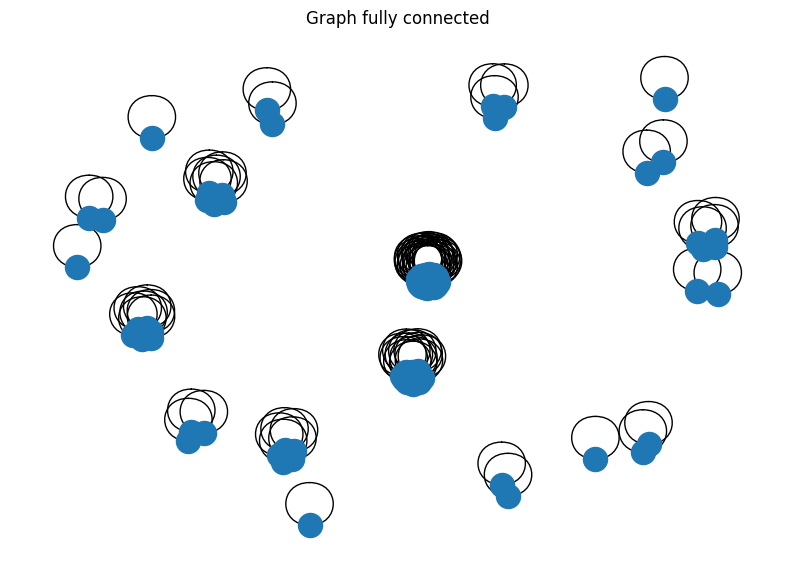

In [9]:
buildgraph.show_graph("Graph fully connected","graph-fc.png")

In [10]:
from sklearn.metrics import euclidean_distances

distance_matrix = euclidean_distances(X_no_sigmut)
max_neighbors = 3

In [11]:
buildgraph.prune_graph(distance_matrix, max_neighbors)

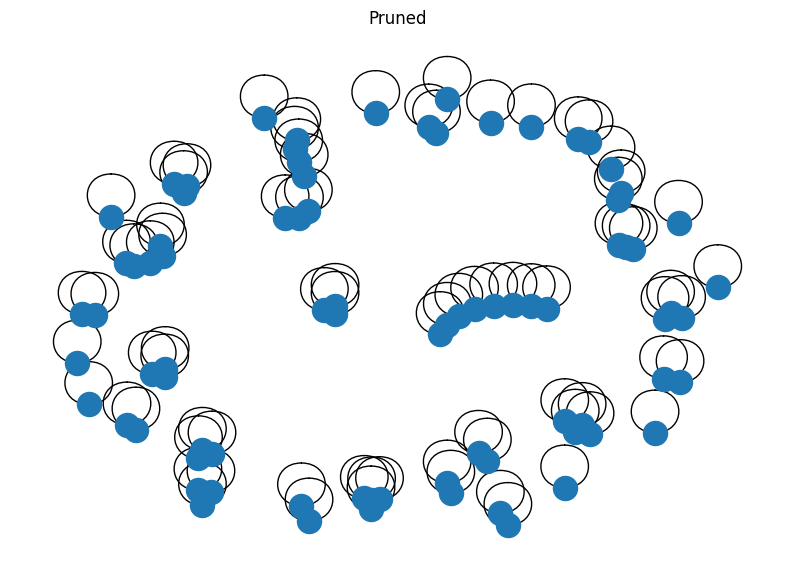

In [12]:
buildgraph.show_graph("Pruned","prune.png")

### 2. Split per KMeans clusters

In [13]:
# Instanciate GCN classifier
gcn_clf_no_sigmut_kmeans = GCNClassifier(len(features_name_no_sigmut))
gcn_clf_sigmut_kmeans = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_no_sigmut_kmeans = GCNClassifierTrainTestManager(gcn_clf_no_sigmut_kmeans)
gcn_manager_sigmut_kmeans = GCNClassifierTrainTestManager(gcn_clf_sigmut_kmeans)

In [14]:
# Group labels for connecting patients (kmeans clusters)
group_no_sigmut_kmeans = KMeans(n_clusters=10).fit(X_no_sigmut).labels_
group_sigmut_kmeans = KMeans(n_clusters=10).fit(X_sigmut).labels_

## No sigmut
test_scores_gcn_no_sigmut_kmeans, test_classes_gcn_no_sigmut_kmeans = gcn_manager_no_sigmut_kmeans.leave_one_out_cross_validation(X_no_sigmut, y_no_sigmut, group_no_sigmut_kmeans, 50)

## Sigmut
test_scores_gcn_sigmut_kmeans, test_classes_gcn_sigmut_kmeans = gcn_manager_sigmut_kmeans.leave_one_out_cross_validation(X_sigmut, y_sigmut, group_sigmut_kmeans, 50)

/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 3. Split per Spectral clustering clusters

In [15]:
# Instanciate GCN classifier
gcn_clf_no_sigmut_spectral = GCNClassifier(len(features_name_no_sigmut))
gcn_clf_sigmut_spectral = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_no_sigmut_spectral = GCNClassifierTrainTestManager(gcn_clf_no_sigmut_spectral)
gcn_manager_sigmut_spectral = GCNClassifierTrainTestManager(gcn_clf_sigmut_spectral)

In [16]:
# Group labels for connecting patients (spectral clustering clusters)
group_no_sigmut_spectral = SpectralClustering(n_clusters=10).fit(X_no_sigmut).labels_
group_sigmut_spectral = SpectralClustering(n_clusters=10).fit(X_sigmut).labels_

## No sigmut
test_scores_gcn_no_sigmut_spectral, test_classes_gcn_no_sigmut_spectral = gcn_manager_no_sigmut_spectral.leave_one_out_cross_validation(X_no_sigmut, y_no_sigmut, group_no_sigmut_spectral, 50)

## Sigmut
test_scores_gcn_sigmut_spectral, test_classes_gcn_sigmut_spectral = gcn_manager_sigmut_spectral.leave_one_out_cross_validation(X_sigmut, y_sigmut, group_sigmut_spectral, 50)

### 4. Split per Hierarchical clustering clusters

In [17]:
# Instanciate GCN classifier
gcn_clf_no_sigmut_hierarchical = GCNClassifier(len(features_name_no_sigmut))
gcn_clf_sigmut_hierarchical = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_no_sigmut_hierarchical = GCNClassifierTrainTestManager(gcn_clf_no_sigmut_hierarchical)
gcn_manager_sigmut_hierarchical = GCNClassifierTrainTestManager(gcn_clf_sigmut_hierarchical)

In [18]:
# Group labels for connecting patients (hierarchical clustering clusters)
group_no_sigmut_hierarchical = AgglomerativeClustering(n_clusters=10).fit(X_no_sigmut).labels_
group_sigmut_hierarchical = AgglomerativeClustering(n_clusters=10).fit(X_sigmut).labels_

## No sigmut
test_scores_gcn_no_sigmut_hierarchical, test_classes_gcn_no_sigmut_hierarchical = gcn_manager_no_sigmut_hierarchical.leave_one_out_cross_validation(X_no_sigmut, y_no_sigmut, group_no_sigmut_hierarchical, 50)

## Sigmut
test_scores_gcn_sigmut_hierarchical, test_classes_gcn_sigmut_hierarchical = gcn_manager_sigmut_hierarchical.leave_one_out_cross_validation(X_sigmut, y_sigmut, group_sigmut_hierarchical, 50)

## 3. Compare models

In [19]:
## Classic classifier - no sigmut
acc_classic_no_sigmut, pre_classic_no_sigmut, rec_classic_no_sigmut, f1_classic_no_sigmut = ClassificationMetrics.eval_metrics_from_conf_matrix(y_no_sigmut, test_classes_classic_no_sigmut)
fpr_classic_no_sigmut, tpr_classic_no_sigmut, thresholds_classic_no_sigmut = ClassificationMetrics.compute_roc_curve(y_no_sigmut, test_scores_classic_no_sigmut)
auc_classic_no_sigmut = ClassificationMetrics.compute_auc(y_no_sigmut, test_scores_classic_no_sigmut)

## Classic classifier - sigmut
acc_classic_sigmut, pre_classic_sigmut, rec_classic_sigmut, f1_classic_sigmut = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_classic_sigmut)
fpr_classic_sigmut, tpr_classic_sigmut, thresholds_classic_sigmut = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_classic_sigmut)
auc_classic_sigmut = ClassificationMetrics.compute_auc(y_sigmut, test_scores_classic_sigmut)

## GCN classifier - tumour type - no sigmut
acc_gcn_no_sigmut_tumour_type, pre_gcn_no_sigmut_tumour_type, rec_gcn_no_sigmut_tumour_type, f1_gcn_no_sigmut_tumour_type = ClassificationMetrics.eval_metrics_from_conf_matrix(y_no_sigmut, test_classes_gcn_no_sigmut_tumour_type)
fpr_gcn_no_sigmut_tumour_type, tpr_gcn_no_sigmut_tumour_type, thresholds_gcn_no_sigmut_tumour_type = ClassificationMetrics.compute_roc_curve(y_no_sigmut, test_scores_gcn_no_sigmut_tumour_type)
auc_gcn_no_sigmut_tumour_type = ClassificationMetrics.compute_auc(y_no_sigmut, test_scores_gcn_no_sigmut_tumour_type)

## GCN classifier - tumour type - sigmut
acc_gcn_sigmut_tumour_type, pre_gcn_sigmut_tumour_type, rec_gcn_sigmut_tumour_type, f1_gcn_sigmut_tumour_type = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_tumour_type)
fpr_gcn_sigmut_tumour_type, tpr_gcn_sigmut_tumour_type, thresholds_gcn_sigmut_tumour_type = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_tumour_type)
auc_gcn_sigmut_tumour_type = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_tumour_type)

## GCN classifier - KMeans - no sigmut
acc_gcn_no_sigmut_kmeans, pre_gcn_no_sigmut_kmeans, rec_gcn_no_sigmut_kmeans, f1_gcn_no_sigmut_kmeans = ClassificationMetrics.eval_metrics_from_conf_matrix(y_no_sigmut, test_classes_gcn_no_sigmut_kmeans)
fpr_gcn_no_sigmut_kmeans, tpr_gcn_no_sigmut_kmeans, thresholds_gcn_no_sigmut_kmeans = ClassificationMetrics.compute_roc_curve(y_no_sigmut, test_scores_gcn_no_sigmut_kmeans)
auc_gcn_no_sigmut_kmeans = ClassificationMetrics.compute_auc(y_no_sigmut, test_scores_gcn_no_sigmut_kmeans)

## GCN classifier - KMeans - sigmut
acc_gcn_sigmut_kmeans, pre_gcn_sigmut_kmeans, rec_gcn_sigmut_kmeans, f1_gcn_sigmut_kmeans = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_kmeans)
fpr_gcn_sigmut_kmeans, tpr_gcn_sigmut_kmeans, thresholds_gcn_sigmut_kmeans = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_kmeans)
auc_gcn_sigmut_kmeans = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_kmeans)

## GCN classifier - Spectral clustering - no sigmut
acc_gcn_no_sigmut_spectral, pre_gcn_no_sigmut_spectral, rec_gcn_no_sigmut_spectral, f1_gcn_no_sigmut_spectral = ClassificationMetrics.eval_metrics_from_conf_matrix(y_no_sigmut, test_classes_gcn_no_sigmut_spectral)
fpr_gcn_no_sigmut_spectral, tpr_gcn_no_sigmut_spectral, thresholds_gcn_no_sigmut_spectral = ClassificationMetrics.compute_roc_curve(y_no_sigmut, test_scores_gcn_no_sigmut_spectral)
auc_gcn_no_sigmut_spectral = ClassificationMetrics.compute_auc(y_no_sigmut, test_scores_gcn_no_sigmut_spectral)

## GCN classifier - Spectral clustering - sigmut
acc_gcn_sigmut_spectral, pre_gcn_sigmut_spectral, rec_gcn_sigmut_spectral, f1_gcn_sigmut_spectral = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_spectral)
fpr_gcn_sigmut_spectral, tpr_gcn_sigmut_spectral, thresholds_gcn_sigmut_spectral = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_spectral)
auc_gcn_sigmut_spectral = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_spectral)

## GCN classifier - Hierarchical clustering - no sigmut
acc_gcn_no_sigmut_hierarchical, pre_gcn_no_sigmut_hierarchical, rec_gcn_no_sigmut_hierarchical, f1_gcn_no_sigmut_hierarchical = ClassificationMetrics.eval_metrics_from_conf_matrix(y_no_sigmut, test_classes_gcn_no_sigmut_hierarchical)
fpr_gcn_no_sigmut_hierarchical, tpr_gcn_no_sigmut_hierarchical, thresholds_gcn_no_sigmut_hierarchical = ClassificationMetrics.compute_roc_curve(y_no_sigmut, test_scores_gcn_no_sigmut_hierarchical)
auc_gcn_no_sigmut_hierarchical = ClassificationMetrics.compute_auc(y_no_sigmut, test_scores_gcn_no_sigmut_hierarchical)

## GCN classifier - Hierarchical clustering - sigmut
acc_gcn_sigmut_hierarchical, pre_gcn_sigmut_hierarchical, rec_gcn_sigmut_hierarchical, f1_gcn_sigmut_hierarchical = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_hierarchical)
fpr_gcn_sigmut_hierarchical, tpr_gcn_sigmut_hierarchical, thresholds_gcn_sigmut_hierarchical = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_hierarchical)
auc_gcn_sigmut_hierarchical = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_hierarchical)

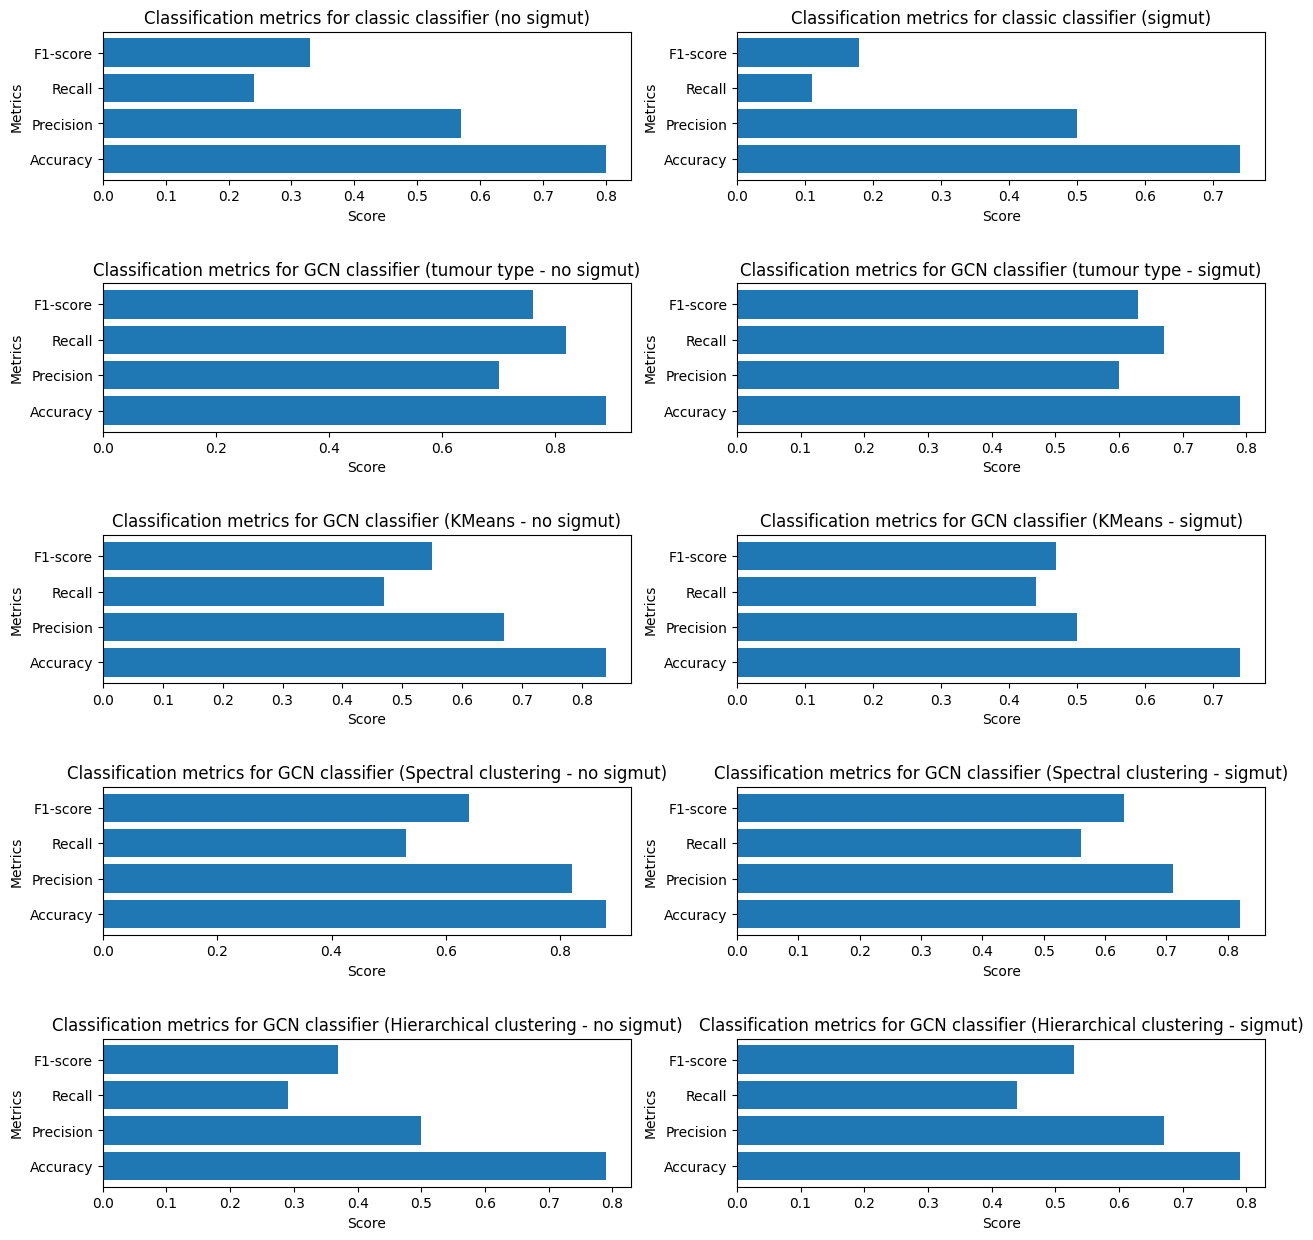

In [20]:
fig, ax = plt.subplots(5,2,figsize=(15,15))

ax[0,0].barh(["Accuracy","Precision","Recall","F1-score"],[acc_classic_no_sigmut, pre_classic_no_sigmut, rec_classic_no_sigmut, f1_classic_no_sigmut])
ax[0,0].set_xlabel("Score")
ax[0,0].set_ylabel("Metrics")
ax[0,0].set_title("Classification metrics for classic classifier (no sigmut)")

ax[0,1].barh(["Accuracy","Precision","Recall","F1-score"],[acc_classic_sigmut, pre_classic_sigmut, rec_classic_sigmut, f1_classic_sigmut])
ax[0,1].set_xlabel("Score")
ax[0,1].set_ylabel("Metrics")
ax[0,1].set_title("Classification metrics for classic classifier (sigmut)")

ax[1,0].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_no_sigmut_tumour_type, pre_gcn_no_sigmut_tumour_type, rec_gcn_no_sigmut_tumour_type, f1_gcn_no_sigmut_tumour_type])
ax[1,0].set_xlabel("Score")
ax[1,0].set_ylabel("Metrics")
ax[1,0].set_title("Classification metrics for GCN classifier (tumour type - no sigmut)")

ax[1,1].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_sigmut_tumour_type, pre_gcn_sigmut_tumour_type, rec_gcn_sigmut_tumour_type, f1_gcn_sigmut_tumour_type])
ax[1,1].set_xlabel("Score")
ax[1,1].set_ylabel("Metrics")
ax[1,1].set_title("Classification metrics for GCN classifier (tumour type - sigmut)")

ax[2,0].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_no_sigmut_kmeans, pre_gcn_no_sigmut_kmeans, rec_gcn_no_sigmut_kmeans, f1_gcn_no_sigmut_kmeans])
ax[2,0].set_xlabel("Score")
ax[2,0].set_ylabel("Metrics")
ax[2,0].set_title("Classification metrics for GCN classifier (KMeans - no sigmut)")

ax[2,1].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_sigmut_kmeans, pre_gcn_sigmut_kmeans, rec_gcn_sigmut_kmeans, f1_gcn_sigmut_kmeans])
ax[2,1].set_xlabel("Score")
ax[2,1].set_ylabel("Metrics")
ax[2,1].set_title("Classification metrics for GCN classifier (KMeans - sigmut)")

ax[3,0].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_no_sigmut_spectral, pre_gcn_no_sigmut_spectral, rec_gcn_no_sigmut_spectral, f1_gcn_no_sigmut_spectral])
ax[3,0].set_xlabel("Score")
ax[3,0].set_ylabel("Metrics")
ax[3,0].set_title("Classification metrics for GCN classifier (Spectral clustering - no sigmut)")

ax[3,1].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_sigmut_spectral, pre_gcn_sigmut_spectral, rec_gcn_sigmut_spectral, f1_gcn_sigmut_spectral])
ax[3,1].set_xlabel("Score")
ax[3,1].set_ylabel("Metrics")
ax[3,1].set_title("Classification metrics for GCN classifier (Spectral clustering - sigmut)")

ax[4,0].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_no_sigmut_hierarchical, pre_gcn_no_sigmut_hierarchical, rec_gcn_no_sigmut_hierarchical, f1_gcn_no_sigmut_hierarchical])
ax[4,0].set_xlabel("Score")
ax[4,0].set_ylabel("Metrics")
ax[4,0].set_title("Classification metrics for GCN classifier (Hierarchical clustering - no sigmut)")

ax[4,1].barh(["Accuracy","Precision","Recall","F1-score"],[acc_gcn_sigmut_hierarchical, pre_gcn_sigmut_hierarchical, rec_gcn_sigmut_hierarchical, f1_gcn_sigmut_hierarchical])
ax[4,1].set_xlabel("Score")
ax[4,1].set_ylabel("Metrics")
ax[4,1].set_title("Classification metrics for GCN classifier (Hierarchical clustering - sigmut)")

plt.subplots_adjust(hspace=0.7)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


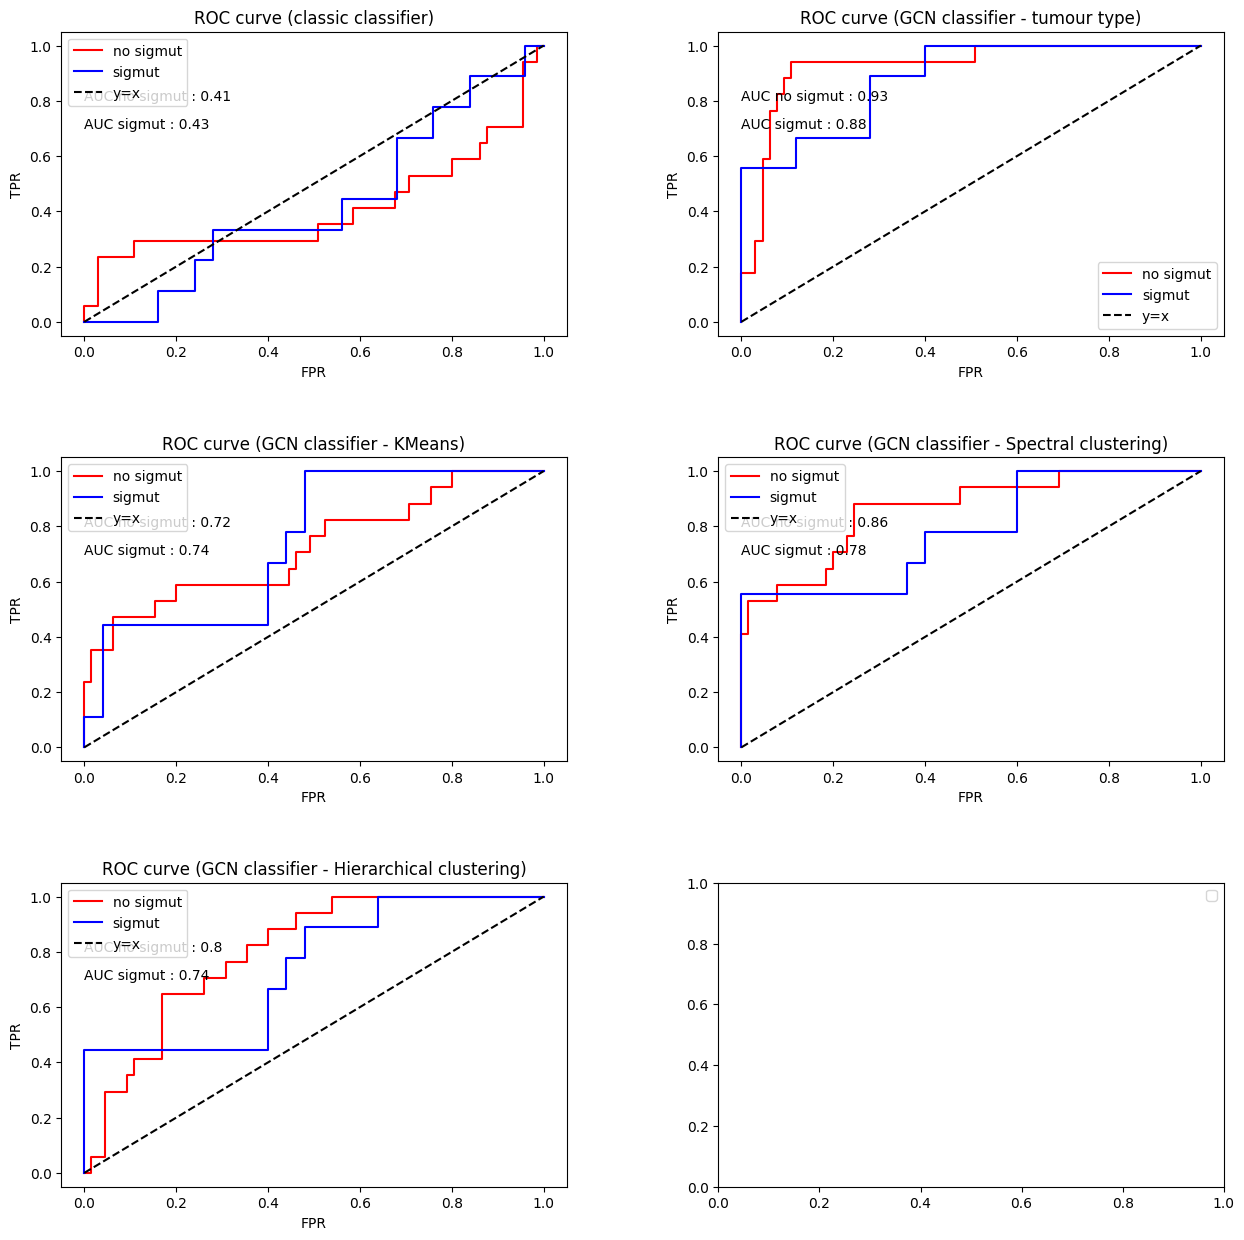

In [21]:
fig, ax = plt.subplots(3,2,figsize=(15,15))
x = np.linspace(0,1,100)

# Classic classifier :
ax[0,0].plot(fpr_classic_no_sigmut, tpr_classic_no_sigmut, color='red',label='no sigmut')
ax[0,0].plot(fpr_classic_sigmut, tpr_classic_sigmut, color='blue',label='sigmut')
ax[0,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[0,0].set_xlabel('FPR')
ax[0,0].set_ylabel('TPR')
ax[0,0].set_title('ROC curve (classic classifier)')
ax[0,0].legend()
ax[0,0].text(0,0.8,f"AUC no sigmut : {auc_classic_no_sigmut}")
ax[0,0].text(0,0.7,f"AUC sigmut : {auc_classic_sigmut}")

# GCN classifier - tumour type :
ax[0,1].plot(fpr_gcn_no_sigmut_tumour_type, tpr_gcn_no_sigmut_tumour_type, color='red',label='no sigmut')
ax[0,1].plot(fpr_gcn_sigmut_tumour_type, tpr_gcn_sigmut_tumour_type, color='blue',label='sigmut')
ax[0,1].plot(x,x,linestyle='--',color='black',label='y=x')
ax[0,1].set_xlabel('FPR')
ax[0,1].set_ylabel('TPR')
ax[0,1].set_title('ROC curve (GCN classifier - tumour type)')
ax[0,1].legend()
ax[0,1].text(0,0.8,f"AUC no sigmut : {auc_gcn_no_sigmut_tumour_type}")
ax[0,1].text(0,0.7,f"AUC sigmut : {auc_gcn_sigmut_tumour_type}")

# GCN classifier - KMeans :
ax[1,0].plot(fpr_gcn_no_sigmut_kmeans, tpr_gcn_no_sigmut_kmeans, color='red',label='no sigmut')
ax[1,0].plot(fpr_gcn_sigmut_kmeans, tpr_gcn_sigmut_kmeans, color='blue',label='sigmut')
ax[1,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[1,0].set_xlabel('FPR')
ax[1,0].set_ylabel('TPR')
ax[1,0].set_title('ROC curve (GCN classifier - KMeans)')
ax[1,0].legend()
ax[1,0].text(0,0.8,f"AUC no sigmut : {auc_gcn_no_sigmut_kmeans}")
ax[1,0].text(0,0.7,f"AUC sigmut : {auc_gcn_sigmut_kmeans}")

# GCN classifier - Spectral clustering :
ax[1,1].plot(fpr_gcn_no_sigmut_spectral, tpr_gcn_no_sigmut_spectral, color='red',label='no sigmut')
ax[1,1].plot(fpr_gcn_sigmut_spectral, tpr_gcn_sigmut_spectral, color='blue',label='sigmut')
ax[1,1].plot(x,x,linestyle='--',color='black',label='y=x')
ax[1,1].set_xlabel('FPR')
ax[1,1].set_ylabel('TPR')
ax[1,1].set_title('ROC curve (GCN classifier - Spectral clustering)')
ax[1,1].legend()
ax[1,1].text(0,0.8,f"AUC no sigmut : {auc_gcn_no_sigmut_spectral}")
ax[1,1].text(0,0.7,f"AUC sigmut : {auc_gcn_sigmut_spectral}")

# GCN classifier - Hierarchical clustering :
ax[2,0].plot(fpr_gcn_no_sigmut_hierarchical, tpr_gcn_no_sigmut_hierarchical, color='red',label='no sigmut')
ax[2,0].plot(fpr_gcn_sigmut_hierarchical, tpr_gcn_sigmut_hierarchical, color='blue',label='sigmut')
ax[2,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[2,0].set_xlabel('FPR')
ax[2,0].set_ylabel('TPR')
ax[2,0].set_title('ROC curve (GCN classifier - Hierarchical clustering)')
ax[2,0].legend()
ax[2,0].text(0,0.8,f"AUC no sigmut : {auc_gcn_no_sigmut_hierarchical}")
ax[2,0].text(0,0.7,f"AUC sigmut : {auc_gcn_sigmut_hierarchical}")

plt.legend()
plt.subplots_adjust(wspace=0.3,hspace=0.4)